In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(tensorflow.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def augment_audio(audio, sr):
    # Ajout de bruit
    noise = np.random.randn(len(audio)) * 0.005
    audio_with_noise = audio + noise
    
    # Modifier la hauteur en fréquence
    try:
        pitch_factor = np.random.uniform(-5, 5)  # En demi-tons
        audio_pitch_shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=pitch_factor)
    except:
        audio_pitch_shifted = audio

    # Modifier la vitesse
    audio_stretched = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))
    
    return [audio_with_noise, audio_pitch_shifted, audio_stretched]


In [3]:
def pad_or_truncate_mfcc(mfccs, fixed_length):
    """
    Ajuste la longueur des MFCCs (40, T) à (40, fixed_length)
    - Tronque si T > fixed_length
    - Ajoute du padding (zéros) si T < fixed_length
    """
    length = mfccs.shape[1]
    if length > fixed_length:
        mfccs = mfccs[:, :fixed_length]
    elif length < fixed_length:
        pad_width = fixed_length - length
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    return mfccs

In [4]:
def extract_features_with_augmentation(file_path, fixed_length):
    try:
        audio, sr = librosa.load(file_path, duration=30)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfccs = pad_or_truncate_mfcc(mfccs, fixed_length)

        # Augmentations
        augmented_audios = augment_audio(audio, sr)
        augmented_mfccs = []
        for a in augmented_audios:
            m = librosa.feature.mfcc(y=a, sr=sr, n_mfcc=40)
            m = pad_or_truncate_mfcc(m, fixed_length)
            augmented_mfccs.append(m)

        # On renvoie la liste (original + augmentations) directement sous forme (40, T)
        all_mfccs = [mfccs] + augmented_mfccs
        return all_mfccs
    except Exception as e:
        print(f"Erreur lors du traitement du fichier {file_path}: {e}")
        return []

In [5]:
def load_audio_features_with_augmentation(data_path, fixed_length):
    genres = os.listdir(data_path)
    X_list = []
    y_list = []
    
    for genre in genres:
        genre_path = os.path.join(data_path, genre)
        for file_name in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file_name)
            mfccs_list = extract_features_with_augmentation(file_path, fixed_length=fixed_length)
            for m in mfccs_list:
                # m est de forme (40, fixed_length)
                X_list.append(m)
                y_list.append(genre)

    X = np.array(X_list)  # X: (N, 40, fixed_length)
    y = np.array(y_list)

    # Ajout de la dimension "canal" pour le CNN 2D : (N, 40, fixed_length, 1)
    X = X[..., np.newaxis]
    return X, y

In [6]:
# Exemple d'utilisation
data_path = "Data/genres_original"
fixed_length = 1293  # A ajuster selon votre dataset (en fonction du sr et hop_length)
X, y = load_audio_features_with_augmentation(data_path, fixed_length)

# Encodage des labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=len(encoder.classes_))

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

/var/folders/g9/jzqz957j1slb_dkhyp9fl5_w0000gn/T/ipykernel_78817/1457872027.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, duration=30)
/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erreur lors du traitement du fichier Data/genres_original/jazz/jazz.00054.wav: 


In [7]:
# Définition du modèle CNN 2D
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(40, fixed_length, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(encoder.classes_), activation='softmax')
])


/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-09 17:35:22.860951: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-09 17:35:22.861360: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-09 17:35:22.861665: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-09 17:35:22.861762: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-09 17:35:22.861956: I tensorflow/core/common_runtime/pluggable_device/pl

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, 
                    batch_size=32, callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Précision sur l'ensemble de test : {accuracy * 100:.2f}%")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 1291, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 1291, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 645, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 645, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 643, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 643, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 321, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 321, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 319, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 319, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 159, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 159, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61056)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    15,630,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,759,370 (60.12 MB)

 Trainable params: 15,758,410 (60.11 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50


2024-12-09 17:39:43.238188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-12-09 17:39:43.246574: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.3363 - loss: 2.0170 - val_accuracy: 0.1797 - val_loss: 2.7403
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.6601 - loss: 0.9981 - val_accuracy: 0.1734 - val_loss: 3.1522
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.8232 - loss: 0.5509 - val_accuracy: 0.4547 - val_loss: 2.0038
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.8846 - loss: 0.3750 - val_accuracy: 0.4750 - val_loss: 2.0855
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.9460 - loss: 0.1931 - val_accuracy: 0.5875 - val_loss: 1.7919
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.9724 - loss: 0.1010 - val_accuracy: 0.7172 - val_loss: 1.0001
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.9839 - loss: 0.0691 - val_accuracy: 0.7688 - val_loss: 0.8203
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9851 - loss: 0.0620 - val_accuracy: 0.759

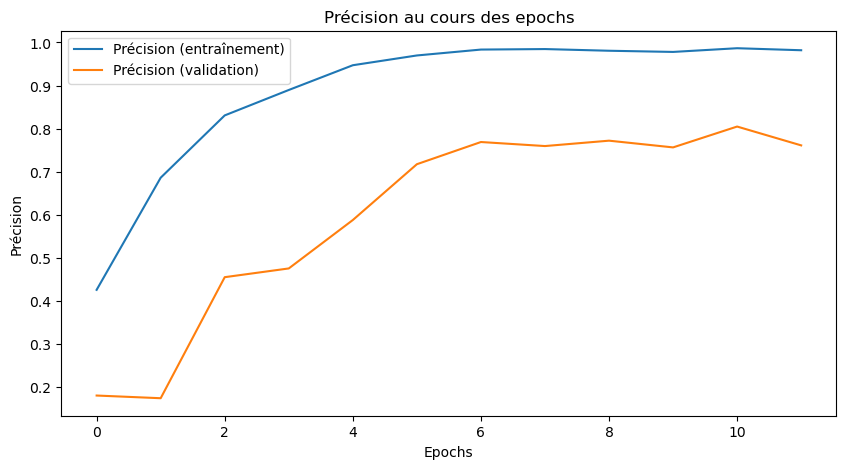

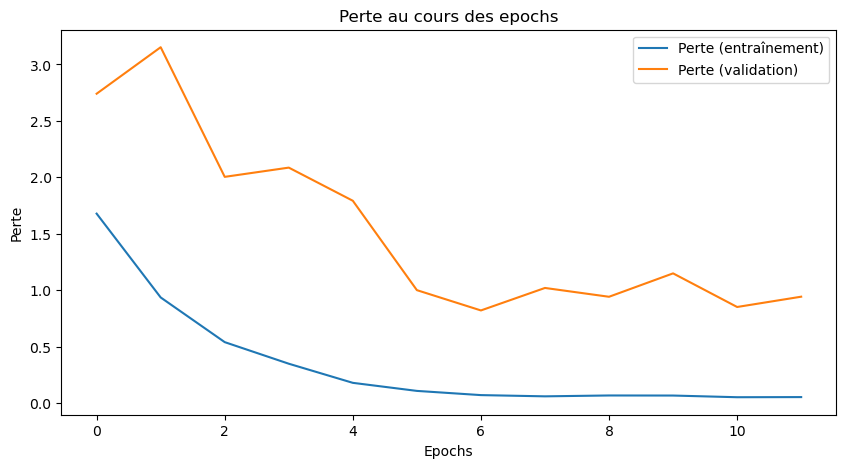

In [12]:
# Précision
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Précision (entraînement)')
plt.plot(history.history['val_accuracy'], label='Précision (validation)')
plt.title("Précision au cours des epochs")
plt.xlabel("Epochs")
plt.ylabel("Précision")
plt.legend()
plt.show()

# Perte
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Perte (entraînement)')
plt.plot(history.history['val_loss'], label='Perte (validation)')
plt.title("Perte au cours des epochs")
plt.xlabel("Epochs")
plt.ylabel("Perte")
plt.legend()
plt.show()


 4/25 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 

2024-12-09 17:42:19.896542: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


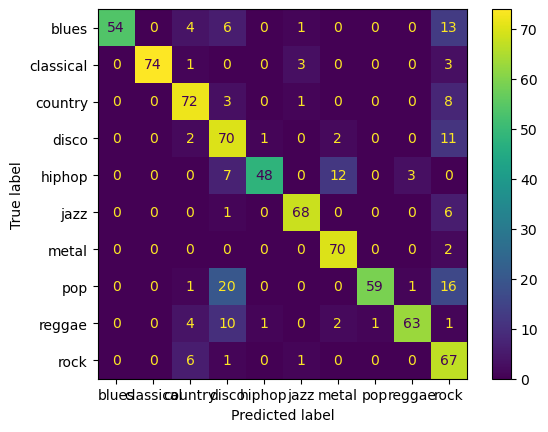

In [13]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=encoder.classes_).plot(cmap='viridis')
plt.show()


In [14]:
import joblib

# Sauvegarde du modèle
model.save('genre_classification_model.h5')

# Sauvegarder l'encodeur après l'entraînement
joblib.dump(encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [15]:
from tensorflow.keras.models import load_model

# Charger le modèle sauvegardé
model = load_model('genre_classification_model.h5')

# Charger l'encodeur des labels
encoder = joblib.load('label_encoder.joblib')

fixed_length = 1293  # Même valeur qu'à l'entraînement

def predict_genre(file_path):
    # Extraire les features sans augmentation (on ne prend que l'original)
    try:
        audio, sr = librosa.load(file_path, duration=30)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfccs = pad_or_truncate_mfcc(mfccs, fixed_length)
        mfccs = mfccs[..., np.newaxis]  # Ajouter la dimension canal
        mfccs = np.expand_dims(mfccs, axis=0)  # Ajouter la dimension batch

        # Prédiction
        predicted_genre_index = np.argmax(model.predict(mfccs), axis=-1)
        predicted_genre = encoder.inverse_transform(predicted_genre_index)[0]
        return predicted_genre
    except Exception as e:
        print(f"Erreur lors de la prédiction : {e}")
        return None

In [16]:
import yt_dlp as youtube_dl
import os

def download_youtube_audio(youtube_url, output_path="downloaded_audio.wav"):
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': 'temp_audio.%(ext)s',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
    }
    
    # Télécharger l'audio
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])
    
    # Renommer le fichier pour l'utiliser
    if os.path.exists("temp_audio.wav"):
        os.rename("temp_audio.wav", output_path)
        print(f"Audio téléchargé et sauvegardé sous : {output_path}")
    else:
        print("Erreur lors du téléchargement.")

# Exemple d'utilisation
youtube_url = "https://youtu.be/tAGnKpE4NCI?si=6me8uc6lZW-LZLrA"
download_youtube_audio(youtube_url, "test_audio.wav")

[youtube] Extracting URL: https://youtu.be/tAGnKpE4NCI?si=6me8uc6lZW-LZLrA
[youtube] tAGnKpE4NCI: Downloading webpage
[youtube] tAGnKpE4NCI: Downloading ios player API JSON
[youtube] tAGnKpE4NCI: Downloading mweb player API JSON
[youtube] tAGnKpE4NCI: Downloading m3u8 information
[info] tAGnKpE4NCI: Downloading 1 format(s): 251
[download] Destination: temp_audio.webm
[download] 100% of    6.33MiB in 00:00:00 at 25.65MiB/s  
[ExtractAudio] Destination: temp_audio.wav
Deleting original file temp_audio.webm (pass -k to keep)
Audio téléchargé et sauvegardé sous : test_audio.wav


In [17]:
# Test avec le fichier téléchargé 
predicted_genre = predict_genre("test_audio.wav")
print(f"Le genre prédit pour test_audio.wav est : {predicted_genre}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Le genre prédit pour test_audio.wav est : country
